In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


C:\Users\keert\SmartEnergyProject\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
df = pd.read_csv("data/House_1_feature_engineered.csv")
df.head()
if 'Time' in df.columns:
    df.drop(columns=['Time'], inplace=True)


In [3]:
y = df['Aggregate']
X = df.drop(columns=['Aggregate'])

X.shape, y.shape


((269635, 22), (269635,))

In [4]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))


In [5]:
train_size = int(len(X_scaled) * 0.7)
val_size = int(len(X_scaled) * 0.15)

X_train = X_scaled[:train_size]
X_val   = X_scaled[train_size:train_size + val_size]
X_test  = X_scaled[train_size + val_size:]

y_train = y_scaled[:train_size]
y_val   = y_scaled[train_size:train_size + val_size]
y_test  = y_scaled[train_size + val_size:]


In [6]:
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

lookback = 24

X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, lookback)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, lookback)

X_train_seq.shape, y_train_seq.shape


((188720, 24, 22), (188720, 1))

In [7]:
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)


Epoch 1/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 9.6002e-04 - val_loss: 0.0011
Epoch 2/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 7.3822e-04 - val_loss: 0.0012
Epoch 3/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - loss: 7.0608e-04 - val_loss: 0.0011
Epoch 4/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 6.9008e-04 - val_loss: 0.0013
Epoch 5/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 6.8894e-04 - val_loss: 0.0012
Epoch 6/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 6.8294e-04 - val_loss: 0.0013
Epoch 7/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 6.7442e-04 - val_loss: 0.0014
Epoch 8/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 6.6803e-04 - val_loss: 0.0013
Epoch 9/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 6.6984e-04 - val_loss: 0.0013
Epoch 10/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 6.6695e-04 - val_loss: 0.0013
Epoch 11/20
5898/5898 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - loss: 6.633

In [9]:
y_test_pred = model.predict(X_test_seq)

lstm_mae = mean_absolute_error(y_test_seq, y_test_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
lstm_r2 = r2_score(y_test_seq, y_test_pred)

lstm_mae, lstm_rmse, lstm_r2


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


(0.008000906073022325, np.float64(0.02426234228174005), 0.422449805808929)

In [11]:
# Baseline metrics from Module 4 (test set)
baseline_mae = 130.1952214296498 
baseline_rmse = 408.13082619298825


In [12]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression (Baseline)', 'LSTM'],
    'MAE': [baseline_mae, lstm_mae],
    'RMSE': [baseline_rmse, lstm_rmse]
})

comparison


,Model,MAE,RMSE
0,Linear Regression (Baseline),130.195221,408.130826
1,LSTM,0.008001,0.024262


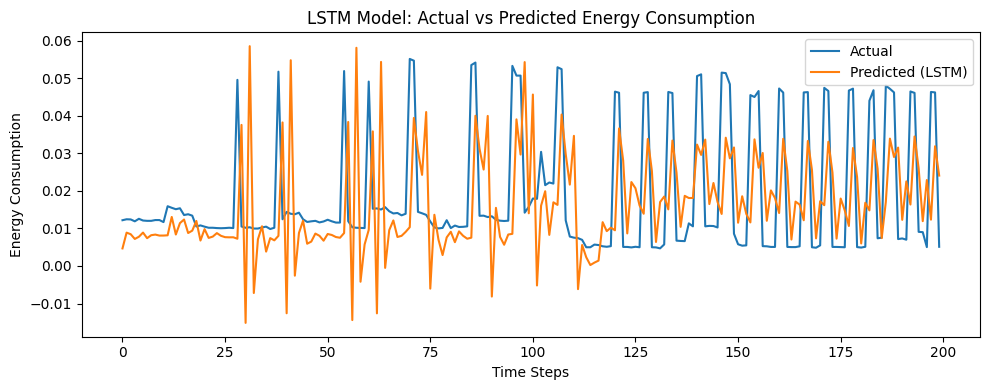

In [13]:
plt.figure(figsize=(10,4))
plt.plot(y_test_seq[:200], label='Actual')
plt.plot(y_test_pred[:200], label='Predicted (LSTM)')
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
model.save("lstm_energy_model.keras")
